In [1]:
import kala
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

## Prelimaries

In [2]:
def _helper_diagonal_sbm(num_nodes, p_off, p_diag=1.0, seed=0, return_pos=True):
    n = num_nodes // 2
    sizes = [n, n + num_nodes % 2]

    p_mat = [
        [p_diag, p_off],
        [p_off, p_diag],
    ]

    g = nx.stochastic_block_model(sizes, p_mat, seed=seed)
    # g.graph["partition"]

    return g


def _helper_two_group_assigment(num_nodes, thresholds, seed=0):
    rng = np.random.default_rng(seed)

    n = num_nodes // 2
    sizes = [n, n + num_nodes % 2]
    block1 = rng.random(size=n) < thresholds[0]
    block2 = rng.random(size=n + num_nodes % 2) < thresholds[1]

    return np.hstack((block1, block2))


def _get_metrics(game, is_saver=None):
    n = game.get_num_players()
    return (
        game.get_total_wealth() / n,
        game.get_num_savers() / n,
        # game.get_total_wealth(filt=is_saver),
        # game.get_total_wealth(filt=~is_saver),
    )

In [3]:
def helper_init(
    num_players,
    group_thresholds,
    differential_efficient,
    differential_inefficient,
    sigma,
    memory_length,
    update_rule,
    rng=0,
):
    # Initialise strategy
    strategy = kala.CooperationStrategy(
        stochastic=True,
        rng=rng,
        differential_efficient=differential_efficient,
        differential_inefficient=differential_inefficient,
        dist_sigma_func=sigma,
    )

    # Initialise players
    is_saver = _helper_two_group_assigment(num_players, thresholds=group_thresholds)
    players = [
        kala.InvestorAgent(
            is_saver=s,
            update_from_n_last_games=memory_length,
            update_rule=update_rule,
        )
        for s in is_saver
    ]

    # Initialise network
    g = _helper_diagonal_sbm(num_players, p_off=0.1)
    G = kala.SimpleGraph(g, nodes=players)

    # Combine everything and initialise game
    game = kala.DiscreteTwoByTwoGame(G, strategy)

    return game, g, is_saver  # g, is_saver: returned for plotting


def helper_run_simulation(game, num_steps):
    game.reset_agents()

    data = [_get_metrics(game)]

    for _ in range(num_steps):
        game.play_round()
        data.append(_get_metrics(game))

    is_saver_final = [player.get_trait("is_saver") for player in game._players]

    return pd.DataFrame(data, columns=["avg_wealth", "frac_savers"]), is_saver_final


def helper_plot_simulation(df, g, savers_init, savers_final):
    pos = nx.spring_layout(g, seed=0)

    fig, axs = plt.subplots(ncols=3, figsize=(12, 4), width_ratios=(1, 1, 2))

    ax = axs[0]
    nx.draw(g, node_color=savers_init, pos=pos, ax=ax)
    ax.set_title("Init")

    ax = axs[1]
    nx.draw(g, node_color=savers_final, pos=pos, ax=ax)
    ax.set_title("Final")

    ax = axs[2]
    axes = [ax, ax.twinx()]

    for column, color, axis in zip(df.columns, ["C0", "C1"], axes):
        df[column].plot(color=color, ax=axis)
        axis.tick_params(axis="y", labelcolor=color)
        axis.set_ylabel(column, color=color);

## Simulations

### Homogeneous mixing (two groups equally mixed)




I start with two groups that are equally mixed and I observe a very stubborn tendency to "disappear" the group of non-savers.

I was interested in three main sources of variability:
1. The efficient and inefficient differentials
2. The variance chosen
3. The memory

#### 1. differentials

In the simulations below, I change the differentials, starting with a variance that has a positive derivative (it might not be a useful one just yet).

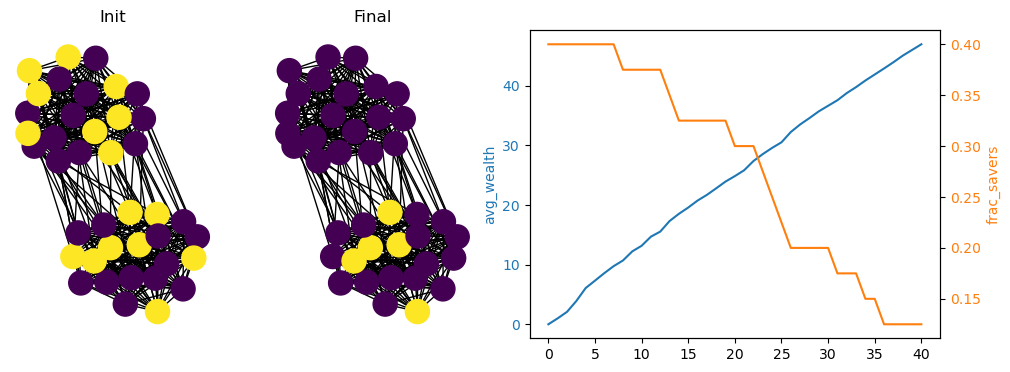

In [53]:
num_players = 40
group_thresholds = [0.5, 0.5]


# Strategy parameters
differential_efficient = 0.15  # <------ changing here
differential_inefficient = 0.05  # <------ ... and here
sigma = lambda x: np.power(x, 2)


# Agent parameters
memory_length = 10
update_rule = kala.models.memory_rules.AverageMemoryRule()
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()


# Init
game, g, savers_init = helper_init(
    num_players,
    group_thresholds,
    differential_efficient,
    differential_inefficient,
    sigma,
    memory_length,
    update_rule,
)

num_steps = 40

df, savers_final = helper_run_simulation(game, num_steps)

helper_plot_simulation(df, g, savers_init, savers_final)

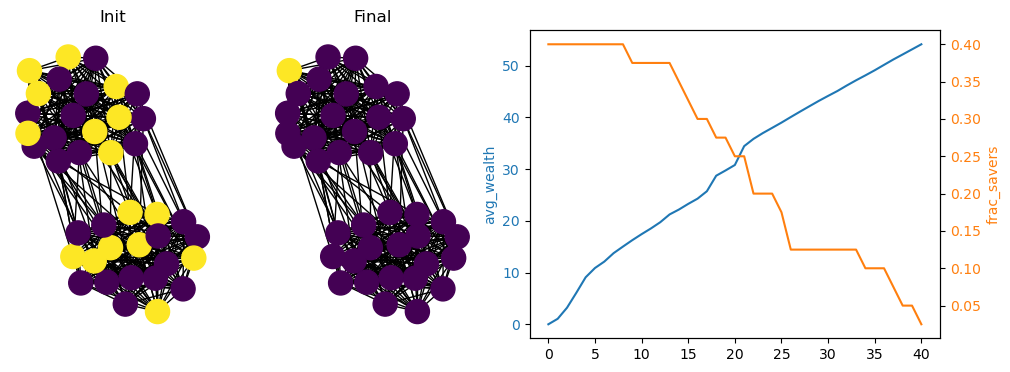

In [56]:
num_players = 40
group_thresholds = [0.5, 0.5]


# Strategy parameters
differential_efficient = 0.3  # <------ changing here
differential_inefficient = 0.1  # <------ ... and here
sigma = lambda x: np.power(x, 2)


# Agent parameters
memory_length = 10
update_rule = kala.models.memory_rules.AverageMemoryRule()
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()


# Init
game, g, savers_init = helper_init(
    num_players,
    group_thresholds,
    differential_efficient,
    differential_inefficient,
    sigma,
    memory_length,
    update_rule,
)

num_steps = 40

df, savers_final = helper_run_simulation(game, num_steps)

helper_plot_simulation(df, g, savers_init, savers_final)

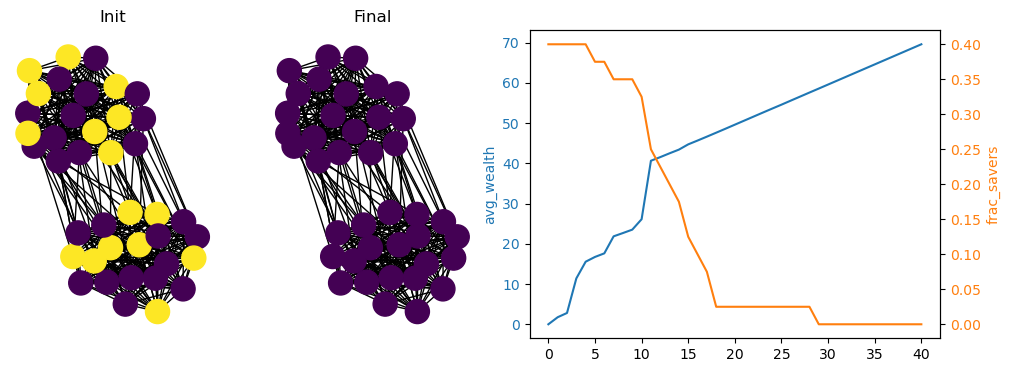

In [63]:
num_players = 40
group_thresholds = [0.5, 0.5]


# Strategy parameters
differential_efficient = 0.5  # <------ changing here
differential_inefficient = 0.3  # <------ ... and here
sigma = lambda x: np.power(x, 2)


# Agent parameters
memory_length = 10
update_rule = update_rule = kala.models.memory_rules.AverageMemoryRule()
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()


# Init
game, g, savers_init = helper_init(
    num_players,
    group_thresholds,
    differential_efficient,
    differential_inefficient,
    sigma,
    memory_length,
    update_rule,
)

num_steps = 40

df, savers_final = helper_run_simulation(game, num_steps)

helper_plot_simulation(df, g, savers_init, savers_final)

#### 2. sigma

Initially I thought that the behaviour above has to do with the variance. If the variance is high enough, there is a more frequent rate of inefficient investments. So what I do is set a fixed an small sigma that basically makes it so that the distribution returns the mean.

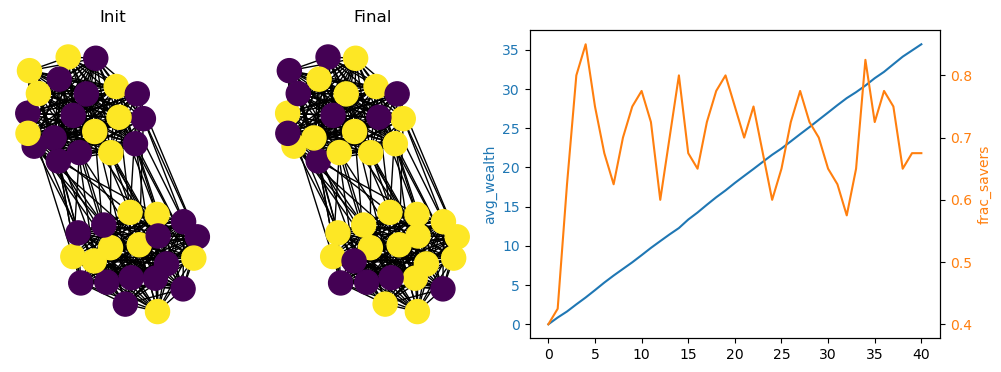

In [15]:
num_players = 40
group_thresholds = [0.5, 0.5]


# Strategy parameters
differential_efficient = 0.2
differential_inefficient = 0.9
sigma = lambda x: 1e-6  # <------ changing here


# Agent parameters
memory_length = 3
update_rule = kala.models.memory_rules.AllPastMemoryRule()
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()


# Init
game, g, savers_init = helper_init(
    num_players,
    group_thresholds,
    differential_efficient,
    differential_inefficient,
    sigma,
    memory_length,
    update_rule,
)

num_steps = 40

df, savers_final = helper_run_simulation(game, num_steps)

helper_plot_simulation(df, g, savers_init, savers_final)

#### 3. A more strict memory rule

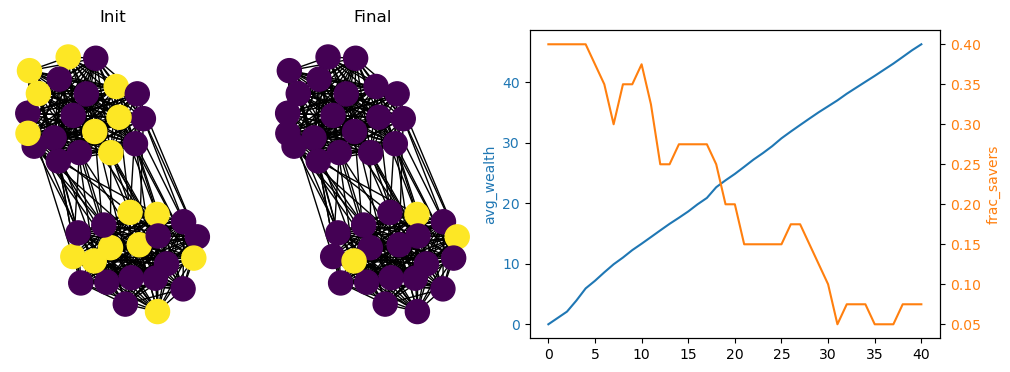

In [68]:
num_players = 40
group_thresholds = [0.5, 0.5]


# Strategy parameters
differential_efficient = 0.15
differential_inefficient = 0.05
sigma = lambda x: np.power(x, 2)


# Agent parameters
memory_length = 10
update_rule = kala.models.memory_rules.FractionMemoryRule(fraction=0.8)  # <------ changing here
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()


# Init
game, g, savers_init = helper_init(
    num_players,
    group_thresholds,
    differential_efficient,
    differential_inefficient,
    sigma,
    memory_length,
    update_rule,
)

num_steps = 40

df, savers_final = helper_run_simulation(game, num_steps)

helper_plot_simulation(df, g, savers_init, savers_final)

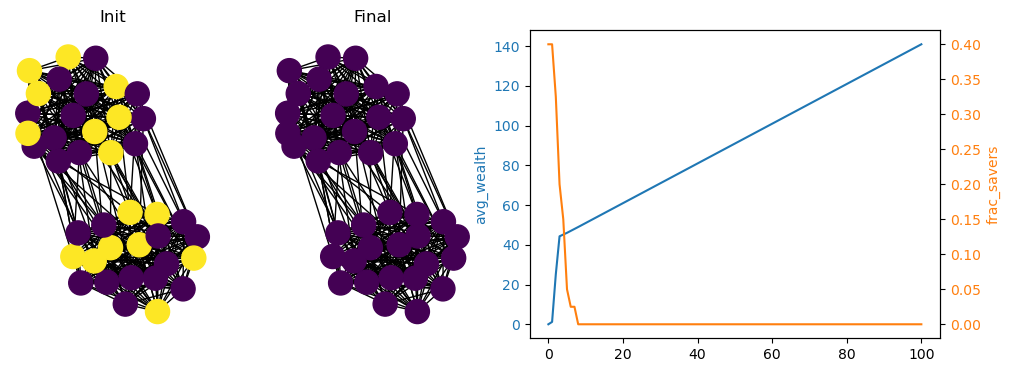

In [12]:
num_players = 40
group_thresholds = [0.5, 0.5]


# Strategy parameters
differential_efficient = 0.9
differential_inefficient = 0.9
sigma = lambda x: np.power(x, 2)


# Agent parameters
memory_length = 3
update_rule = kala.models.memory_rules.AverageMemoryRule()  # <------ changing here
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()


# Init
game, g, savers_init = helper_init(
    num_players,
    group_thresholds,
    differential_efficient,
    differential_inefficient,
    sigma,
    memory_length,
    update_rule,
)

num_steps = 100

df, savers_final = helper_run_simulation(game, num_steps)

helper_plot_simulation(df, g, savers_init, savers_final)

## Differentiated groups

What is interesting from the analysis above is that neither variance nor differnetials change the story much (the fraction of the memory does, there is a critical threshold above which the saver population plateaus). 

What does make a difference is the initial distribution of savers.

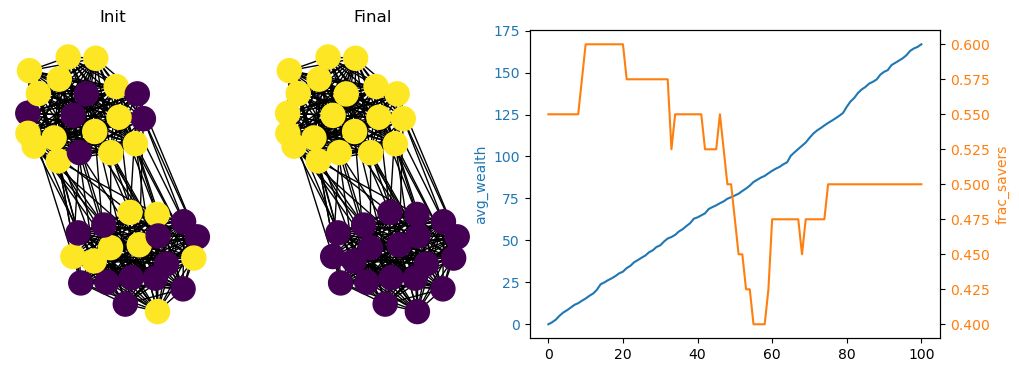

In [74]:
num_players = 40
group_thresholds = [0.8, 0.5]  # <------ changing here


# Strategy parameters
differential_efficient = 0.15
differential_inefficient = 0.05
sigma = lambda x: np.power(x, 2)


# Agent parameters
memory_length = 10
update_rule = kala.models.memory_rules.AverageMemoryRule()
# AverageMemoryRule(), FractionMemoryRule(fraction=0.9), AnyPastMemoryRule(), AllPastMemoryRule()


# Init
game, g, savers_init = helper_init(
    num_players,
    group_thresholds,
    differential_efficient,
    differential_inefficient,
    sigma,
    memory_length,
    update_rule,
)

num_steps = 100

df, savers_final = helper_run_simulation(game, num_steps)

helper_plot_simulation(df, g, savers_init, savers_final)